In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def circle_points_torch(radius, num_points):
    """
    Generate coordinates of points on the circumference of a circle using PyTorch.

    Parameters:
    radius (float): The radius of the circle.
    num_points (int): The number of points to generate on the circumference.

    Returns:
    torch.Tensor: A tensor of shape (num_points, 2) containing the coordinates of the points.
    """
    # Create a tensor of angles evenly spaced around the circle
    angles = torch.linspace(0, 2 * torch.pi, num_points)
    
    # Calculate the x and y coordinates for each point
    x = radius * torch.cos(angles)
    y = radius * torch.sin(angles)
    norm= torch.sqrt( x**2 + y**2 )
    n_x = x / norm
    n_y = y / norm
    points = torch.stack((x, y,n_x,n_y), dim=1)
    return points

def draw_p(l):
    for elem in l:
        plt.scatter(elem[0],elem[1],color="black")

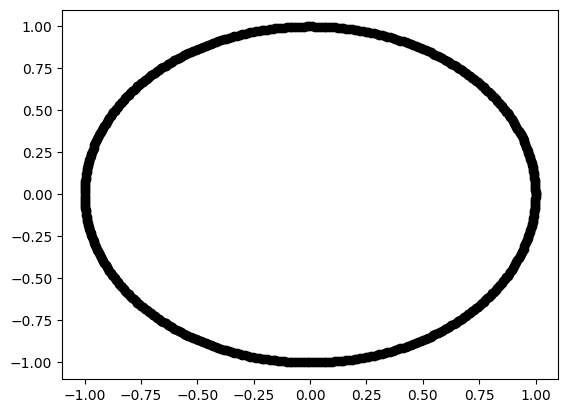

In [3]:
points_c=circle_points_torch(radius=1,num_points=500)
draw_p(points_c)

In [157]:
def get_borders(points):
    min_x=torch.min(points[:,0])
    max_x=torch.max(points[:,0])
    min_y=torch.min(points[:,1])
    max_y=torch.max(points[:,1])
    
    sep_x=torch.sqrt((max_x-min_x)**2)
    sep_y=torch.sqrt((max_y-min_y)**2)
    
    width=max(sep_x,sep_y)
    
    return (min_x,min_x+width,min_y,min_y+width)
    

def create_quadtree(dico,tmp_depth,depth,points,borders,label):
    min_x=borders[0]
    max_x=borders[1]
    min_y=borders[2]
    max_y=borders[3]
    
    sep_x=min_x+torch.sqrt((max_x-min_x)**2)/2.0
    sep_y=min_y+torch.sqrt((max_y-min_y)**2)/2.0
    
    
    
    
    mask=(points[:,0]<= sep_x) & (points[:,1]> sep_y)
    hg= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]> sep_y)
    hd= points[mask]
    mask=(points[:,0]<= sep_x) & (points[:,1]<= sep_y)
    bg= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]<= sep_y)
    bd= points[mask]
    
    
    gx=min_x
    gy=sep_y
    dx=sep_x
    dy=max_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"1"]=(tmp_depth,tmp_oc,dx-gx,border,hg)
    
    if (hg.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hg.clone(),border,label+"1")
    
    gx=sep_x
    gy=sep_y
    dx=max_x
    dy=max_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"2"]=(tmp_depth,tmp_oc,dx-gx,border,hd)
    
    if (hd.shape[0]>1)and depth>tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hd.clone(),border,label+"2")
    
    gx=min_x
    gy=min_y
    dx=sep_x
    dy=sep_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"3"]=(tmp_depth,tmp_oc,dx-gx,border,bg)
    
    
    if (bg.shape[0]>1)and depth>tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bg.clone(),border,label+"3")
    
    gx=sep_x
    gy=min_y
    dx=max_x
    dy=sep_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    

    dico[label+"4"]=(tmp_depth,tmp_oc,dx-gx,border,bd)
    
    
    if (bd.shape[0]>1) and depth>tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bd.clone(),border,label+"4")
    
    
    
    
def draw_quadtree(dico):
    fig = plt.figure()
    
    for node in dico:
        depth,_,_,border,l_points=dico[node]
        gx,dx,gy,dy=border
        
        
        if depth==1:
            draw_p(l_points)
        
        plt.plot([gx,dx],[gy,gy],color="blue")
        plt.plot([gx,dx],[dy,dy],color="blue")
        plt.plot([gx,gx],[dy,gy],color="blue")
        plt.plot([dx,dx],[dy,gy],color="blue")
    
    
    

In [196]:
dico=dict()
bord=get_borders(points_c)
create_quadtree(dico,1,15,points_c,bord,"")

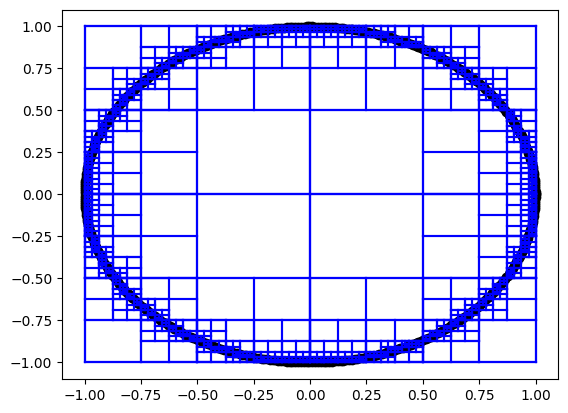

In [197]:
draw_quadtree(dico)

In [198]:
def get_min_width(dico,D):
    min_width=1e9
    for node in dico:
        if (dico[node][2]<min_width and dico[node][0]<=D ):
            min_width=dico[node][2]
    return min_width
        

s_p=points_c[:,:2]


def get_os(nb_s,dico,D):
    cpt_p=0
    s_p=torch.ones((nb_s,4))
    o_s=torch.ones((nb_s,4,4)) #interpolation weight , width , center
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,l_points=dico[node]
            
            for p in l_points:
                s_p[cpt_p]=p.clone()
                gx,dx,gy,dy=dico[node[:-1]][-2]

                tmp_o_vec=torch.empty((4,4))
                for idx_nbgr in range(1,5):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[cpt_p,0]-gx)/(dx-gx)
                    v=(s_p[cpt_p,1]-gy)/(dy-gy)
                    

                    if idx_nbgr==1:
                        tmp_o_vec[0,0]=(1 - u)*v
                    if idx_nbgr==2:
                        tmp_o_vec[1,0]=u*v
                    if idx_nbgr==3:
                        tmp_o_vec[2,0]=(1 - u)*(1 - v)
                    if idx_nbgr==4:
                        tmp_o_vec[3,0]=u*(1 - v)
                
                o_s[cpt_p]=tmp_o_vec.clone()
                cpt_p+=1
    return s_p,o_s
#s_p : (50,4)
#o_s : (50,4,3)

                
                
            
            
s_p,o_s=get_os(points_c.shape[0],dico,5)

#print(o_s.shape)

def get_alpha(s_p,o_s):
    #(100,4,2)
    tmp_mat_sp=torch.empty((o_s.shape[0],o_s.shape[1],o_s.shape[2]-1))
    tmp_mat_sp[:,0,:]=s_p[:,:2]
    tmp_mat_sp[:,1,:]=s_p[:,:2]
    tmp_mat_sp[:,2,:]=s_p[:,:2]
    tmp_mat_sp[:,3,:]=s_p[:,:2]

    #RMSE
    return torch.sum(torch.sqrt((tmp_mat_sp-o_s[:,:,:2])**2),dim=2)

def get_Fo(o_s,q):
    

    arg_f=tmp_mat_sp=torch.empty((o_s.shape[0],o_s.shape[1],o_s.shape[2]-1))
    tmp_mat_sp[:,0,:]=q.clone()
    tmp_mat_sp[:,1,:]=q.clone()
    tmp_mat_sp[:,2,:]=q.clone()
    tmp_mat_sp[:,3,:]=q.clone()
    
    w=o_s[:,:,2].view((o_s.shape[0],o_s.shape[1],1))
    
    
    tmp_mat_sp=(tmp_mat_sp-o_s[:,:,:2])/w
    
    tmp_mat_sp=torch.where(torch.abs(tmp_mat_sp)<0.5,1,0)
    
    tmp_mat_sp=torch.prod(tmp_mat_sp,dim=2)**3
    w=o_s[:,:,2].view((o_s.shape[0],o_s.shape[1]))
    
    return tmp_mat_sp*(1/w**3)  


D=10
l_s,l_o=get_os(s_p.shape[0],dico,D)

def get_V_q(q,l_o,l_s):
    q_vec=torch.empty((l_o.shape[0],4,2))
    q_vec[:,:,0]=q[0]
    q_vec[:,:,1]=q[1]
    
    q_vec[:,:,0]-=l_o[:,:,2]
    q_vec[:,:,0]/=l_o[:,:,1]
    q_vec[:,:,1]-=l_o[:,:,3]
    q_vec[:,:,1]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q_vec)**2,dim=2)/(1.5**2))
    
    
    test=test*l_o[:,:,0]
    
    res=torch.empty((l_o.shape[0],4,2))
    res[:,0]=l_s[:,2:]
    res[:,1]=l_s[:,2:]
    res[:,2]=l_s[:,2:]
    res[:,3]=l_s[:,2:]
    
    res[:,0,0]*=test[:,0]
    res[:,0,1]*=test[:,0]
    res[:,1,0]*=test[:,1]
    res[:,1,1]*=test[:,1]
    res[:,2,0]*=test[:,2]
    res[:,2,1]*=test[:,2]
    res[:,3,0]*=test[:,3]
    res[:,3,1]*=test[:,3]
    res=torch.sum(res,dim=(0,1))
    
    return res
    
    #q_vec=torch.where( (q_vec>=0)&(q_vec<100), )
q=torch.ones(2)
q[0]=-1.
q[1]=0


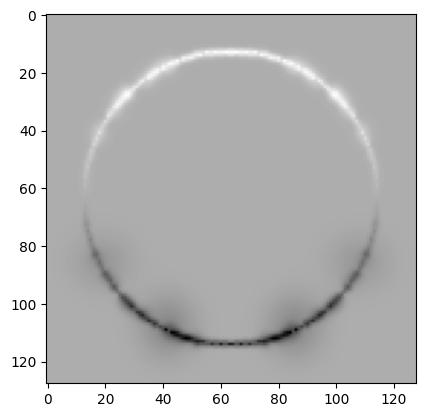

In [199]:
#octree depth
D=8
#grid resolution
n_p=128
#Average density for adaptative depth

image_res=torch.zeros((n_p,n_p,2))
vec=torch.linspace(-1.25,1.25,n_p)


s_p=points_c[:,:2]
l_s,l_o=get_os(s_p.shape[0],dico,D)



for i in range(len(vec)):
    for j in range(len(vec)):
        coords=torch.empty(2)
        coords[0]=vec[i]
        coords[1]=vec[j]
        tmp=get_V_q(coords,l_o,l_s)
        image_res[i][j]=tmp

plt.imshow(torch.sqrt(image_res[:,:,0]**2+image_res[:,:,1]**2),cmap="Greys")
plt.imshow(image_res[:,:,0],cmap="Greys")

In [300]:
def get_V_vec(img,l_o,l_s):
    #img: 32,32,2
    #->32,32,500,4,2
    
    q_vec=torch.clone(img)
    q_vec=q_vec.unsqueeze(2)
    q_vec=q_vec.unsqueeze(3)
    q_vec=q_vec.repeat(1,1,l_o.shape[0],4,1)
    
    q_vec[:,:,:,:,0]-=l_o[:,:,2]
    q_vec[:,:,:,:,0]/=l_o[:,:,1]
    q_vec[:,:,:,:,1]-=l_o[:,:,3]
    q_vec[:,:,:,:,1]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q_vec)**2,dim=4)/(1.5**2))
    

    tmp_Lo=l_o.clone().unsqueeze(0).unsqueeze(0)
    tmp_Lo=tmp_Lo.repeat(img.shape[0],img.shape[0],1,1,1)
    test=(test*tmp_Lo[:,:,:,:,0]).view(img.shape[0],img.shape[0],l_o.shape[0],4,1).repeat(1,1,1,1,2)
    print(test.shape)

    #res=torch.empty((l_o.shape[0],4,2))
    #res[:,0]=l_s[:,2:]

    res=l_o[:,:,2:].clone().unsqueeze(0).unsqueeze(0).repeat(img.shape[0],img.shape[0],1,1,1)
    res=torch.sum(res*test,dim=(2,3))
    
    
    return res

def compute_laplacian(X):
    # Compute the Laplacian using finite differences
    laplacian = -4 * X
    laplacian[:-1, :] += X[1:, :]  # X_{i+1,j}
    laplacian[1:, :] += X[:-1, :]  # X_{i-1,j}
    laplacian[:, :-1] += X[:, 1:]  # X_{i,j+1}
    laplacian[:, 1:] += X[:, :-1]  # X_{i,j-1}
    return laplacian


def compute_divergence(V):
    # Initialize the divergence tensor with the same spatial dimensions, but only one channel
    div_V = torch.zeros((V.shape[0], V.shape[1]))
    
    # Compute the x-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[1:-1, :] += (V[2:, :, 0] - V[:-2, :, 0]) / 2
    
    # Compute the y-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[:, 1:-1] += (V[:, 2:, 1] - V[:, :-2, 1]) / 2
    
    # Handle the borders if necessary (here we assume a zero-gradient boundary condition)
    # This can be replaced with a more appropriate condition for your specific case
    div_V[0, :] += (V[1, :, 0] - V[0, :, 0])
    div_V[-1, :] += (V[-1, :, 0] - V[-2, :, 0])
    div_V[:, 0] += (V[:, 1, 1] - V[:, 0, 1])
    div_V[:, -1] += (V[:, -1, 1] - V[:, -2, 1])

    return div_V

def get_prod_FV(xa, ya,xmin,xmax,ymin,ymax,Width,V):
    X, Y = np.mgrid[xmin:xmax:64j, ymin:ymax:64j]

    X=torch.from_numpy(X)
    Y=torch.from_numpy(Y)
    
    idxs=torch.empty((64,64,2))
    idxs[:,:,0]=X
    idxs[:,:,1]=Y

    res_A = torch.exp(-((X - xa)**2 + (Y - ya)**2) / (Width * 1.5)**2)
    return res_A*V

def get_inner_product_VB(V,borders,D):
    res=torch.empty(4**D)
    borders=get_borders(points_c)

    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()

    #fig = plt.figure(constrained_layout=True,figsize=(10,15))
    #axs = (fig.subplots(4, 4, sharex=False, sharey=False))
    
    


    Width=(max_x-min_x)/(2**D)
    cpt_idx=0

    for i in range(2**D):
        for j in range(2**D):
            
            xa=min_x+(i*Width)+Width/2.0
            ya=min_y+(j*Width)+Width/2.0
            tmp_gauss=get_prod_FV(xa, ya,min_x,max_x,min_y,max_y,Width,V)
            
            #axs[i][j].imshow(tmp_gauss,cmap='gray')
            res[cpt_idx]=torch.sum(tmp_gauss)*(Width**2)
            cpt_idx+=1
    return res


def get_prodB(xa, ya,xb,yb,xmin,xmax,ymin,ymax,Width):
    X, Y = np.mgrid[xmin:xmax:128j, ymin:ymax:128j]

    X=torch.from_numpy(X)
    Y=torch.from_numpy(Y)
    
    idxs=torch.empty((128,128,2))
    idxs[:,:,0]=X
    idxs[:,:,1]=Y

    res_A = torch.exp(-((X - xa)**2 + (Y - ya)**2) / (Width * 1.5)**2)
    res_B = torch.exp(-((X - xb)**2 + (Y - yb)**2) / (Width * 1.5)**2)

    
    
    return (res_A*res_B)*((Width**2) /(128**2))

def get_inner_product_B(borders,D):
    res=torch.empty(4**D,4**D)
    borders=get_borders(points_c)

    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()

    #fig = plt.figure(constrained_layout=True,figsize=(10,15))
    #axs = (fig.subplots(4, 4, sharex=False, sharey=False))
    
    


    Width=(max_x-min_x)/(2**D)
    cpt_vert=0
    for a in range(2**D):
        for b in range(2**D):
            cpt_tmp=0
            xa=min_x+(a*Width)+Width/2.0
            ya=min_y+(b*Width)+Width/2.0
            for i in range(2**D):
                for j in range(2**D):
              
                    
                    xb=min_x+(i*Width)+Width/2.0
                    yb=min_y+(j*Width)+Width/2.0
                    tmp_gauss=get_prodB(xa, ya,xb,yb,min_x,max_x,min_y,max_y,Width)
                    
                    #axs[i][j].imshow(tmp_gauss,cmap='gray')
                    res[cpt_vert,cpt_tmp]=torch.sum(tmp_gauss)
                    cpt_tmp+=1
            cpt_vert+=1
            
    return res

    


torch.Size([64, 64, 500, 4, 2])


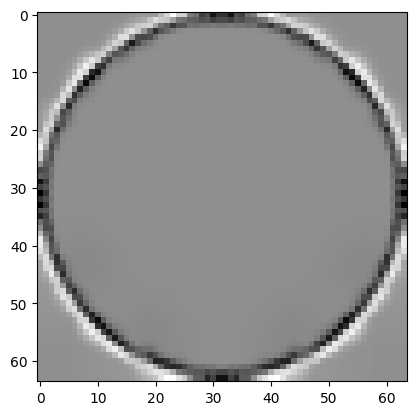

In [311]:
D=8
l_s,l_o=get_os(s_p.shape[0],dico,D)

borders=get_borders(points_c)

min_x=borders[0].item()
max_x=borders[1].item()
min_y=borders[2].item()
max_y=borders[3].item()

X, Y = np.mgrid[min_x:max_x:64j, min_y:max_y:64j]

X=torch.from_numpy(X)
Y=torch.from_numpy(Y)

img=torch.empty((64,64,2))
img[:,:,0]=X
img[:,:,1]=Y


img=get_V_vec(img,l_o,l_s)
#plt.imshow(torch.sqrt(img[:,:,0]**2+img[:,:,1]**2),cmap="Greys")

grad=compute_divergence(img)
plt.imshow(grad,cmap="Greys")

Vo=get_inner_product_VB(grad,borders,2)
BB=get_inner_product_B(borders,2)


torch.Size([16])
torch.Size([16, 16])


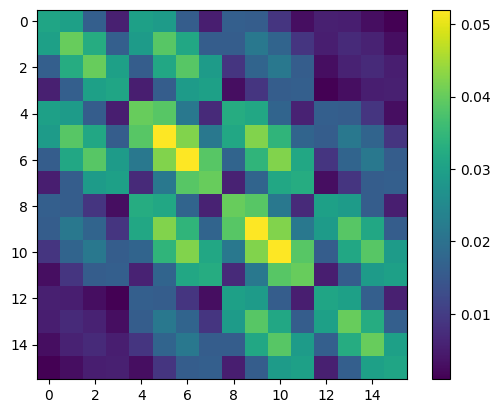

In [312]:
print(Vo.shape)
print(BB.shape)
plt.imshow(BB)
plt.colorbar()